## Load the fMRI file in a subject
 - load the data
 - check headers and condfigs 
 - reconstruced k-space 2 image space with IFFT
 - plot the k-space and image space
 - plot different files in the subjects 
 - plot all slices 
 - plot all coils across slices 
 


In [1]:
# import libraraies 
import numpy as np 
from numpy.fft import fftshift, ifftshift, ifftn, fftn
import twixtools 
import matplotlib.pyplot as plt 
%matplotlib inline 
import time
import random
import os
import sys

# define subject path 
sub_path = "/Users/faizan/Documents/freezemotion/fmri_reco/implementations/twixtools/example_data"
sub_file = "meas_MID00046_FID80431_cmrr_mbep2d_videos_AP_RDS.dat"
full_sub_file_path = os.path.join(sub_path, sub_file)


# check if the path exists
if os.path.exists(full_sub_file_path):
    pass
else:
    # raise path not found error
    raise FileNotFoundError(f'File not found: {full_sub_file_path}')


In [2]:
# some helper functions 
def ifftnd(kspace, axes=[-1]):
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

# Get the MB factor from the header
def recursive_search(obj, keyname):
    if isinstance(obj, dict):
        for k, v in obj.items():
            if keyname == k:
                print("FOUND:", keyname, "-->", v)
            recursive_search(v, keyname)
    elif isinstance(obj, list):
        for item in obj:
            recursive_search(item, keyname)
            
# example usage
# hdr = twix_raw[-1]['hdr']
# recursive_search(hdr, "lMultiBandFactor")

# Alternative implementation that also shows the path to the key
def find_key_paths(obj, keyname, path="hdr"):
    if isinstance(obj, dict):
        for k, v in obj.items():
            new_path = f"{path}['{k}']"
            if k == keyname:
                print("FOUND at:", new_path, "-->", v)
            find_key_paths(v, keyname, new_path)
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            new_path = f"{path}[{i}]"
            find_key_paths(item, keyname, new_path)
# example usage
# find_key_paths(hdr, "lMultiBandFactor")
# Now we know that the MB factor is 4


In [3]:
twix_raw = twixtools.read_twix(full_sub_file_path)
epi_map  = twixtools.map_twix(twix_raw)

print("Measurements:", len(epi_map))

print("Keys Measurment 0:", epi_map[0].keys())
print("Keys measurement 1:", epi_map[-1].keys())

Software version: VD/VE (!?)

Scan  0


100%|██████████| 70.6M/70.6M [00:00<00:00, 1.71GB/s]



Scan  1


100%|██████████| 11.1G/11.1G [00:09<00:00, 1.24GB/s]
100%|██████████| 11.1G/11.1G [00:09<00:00, 1.24GB/s]


Measurements: 2
Keys Measurment 0: dict_keys(['noise', 'image', 'rt_feedback', 'hdr', 'hdr_str'])
Keys measurement 1: dict_keys(['noise', 'phasecorr', 'image', 'rt_feedback', 'hdr', 'hdr_str'])


Reference scan details 
 - MB factor 
 - Undersampling factor 
 - other headers
 

In [4]:
# MB factor in the ref scan 
hdr = twix_raw[0]['hdr']
print(recursive_search(hdr, "lMultiBandFactor"))

# find with the key details 
find_key_paths(hdr, "lMultiBandFactor")

print(f'CAIPI shift factor: {find_key_paths(hdr, "lFOVShiftFactor")}')
print(f'Inplane acceleration factor: {find_key_paths(hdr, "lAccelFactPE")}')

FOUND: lMultiBandFactor --> 1
FOUND: lMultiBandFactor --> 1
FOUND: lMultiBandFactor --> 4
None
FOUND at: hdr['Meas']['lMultiBandFactor'] --> 1
FOUND at: hdr['MeasYaps']['sSliceAcceleration']['lMultiBandFactor'] --> 1
FOUND at: hdr['Phoenix']['sSliceAcceleration']['lMultiBandFactor'] --> 4
FOUND at: hdr['Meas']['lFOVShiftFactor'] --> 1
FOUND at: hdr['MeasYaps']['sSliceAcceleration']['lFOVShiftFactor'] --> 1
FOUND at: hdr['Phoenix']['sSliceAcceleration']['lFOVShiftFactor'] --> 2
CAIPI shift factor: None
FOUND at: hdr['Dicom']['lAccelFactPE'] --> 1
FOUND at: hdr['Meas']['lAccelFactPE'] --> 1
FOUND at: hdr['MeasYaps']['sPat']['lAccelFactPE'] --> 1
FOUND at: hdr['Phoenix']['sPat']['lAccelFactPE'] --> 1
Inplane acceleration factor: None


main scan 

In [5]:
# MB factor in the main scan 
hdr = twix_raw[-1]['hdr']
print(recursive_search(hdr, "lMultiBandFactor"))

# find with the key details 
find_key_paths(hdr, "lMultiBandFactor")

print(f'CAIPI shift factor: {find_key_paths(hdr, "lFOVShiftFactor")}')
print(f'Inplane acceleration factor: {find_key_paths(hdr, "lAccelFactPE")}')

FOUND: lMultiBandFactor --> 4
FOUND: lMultiBandFactor --> 4
FOUND: lMultiBandFactor --> 4
None
FOUND at: hdr['Meas']['lMultiBandFactor'] --> 4
FOUND at: hdr['MeasYaps']['sSliceAcceleration']['lMultiBandFactor'] --> 4
FOUND at: hdr['Phoenix']['sSliceAcceleration']['lMultiBandFactor'] --> 4
FOUND at: hdr['Meas']['lFOVShiftFactor'] --> 2
FOUND at: hdr['MeasYaps']['sSliceAcceleration']['lFOVShiftFactor'] --> 2
FOUND at: hdr['Phoenix']['sSliceAcceleration']['lFOVShiftFactor'] --> 2
CAIPI shift factor: None
FOUND at: hdr['Dicom']['lAccelFactPE'] --> 1
FOUND at: hdr['Meas']['lAccelFactPE'] --> 1
FOUND at: hdr['MeasYaps']['sPat']['lAccelFactPE'] --> 1
FOUND at: hdr['Phoenix']['sPat']['lAccelFactPE'] --> 1
Inplane acceleration factor: None


In [6]:
ref_scan = epi_map[0]["image"]
main_scan = epi_map[-1]["image"]
phase_corr_main_scan = epi_map[-1]["phasecorr"]

# each array is <class 'twixtools.map_twix.twix_array'> data type
print(f'ref scan shape: {ref_scan.shape}')
print(f'main scan shape: {main_scan.shape}')
print(f'main phase correction scan shape: {phase_corr_main_scan.shape}')
print(f'Non singleton dimensions main scan: {main_scan.non_singleton_dims}')

ref scan shape: (1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 32, 1, 1, 32, 38, 128)
main scan shape: (1, 1, 1, 1, 1, 1, 1, 485, 1, 1, 1, 36, 1, 64, 38, 128)
main phase correction scan shape: (1, 1, 1, 1, 1, 1, 1, 485, 1, 1, 1, 36, 1, 33, 38, 128)
Non singleton dimensions main scan: ['Rep', 'Sli', 'Lin', 'Cha', 'Col']


plot main scan

In [7]:
print(f'Non singleton dimensions measrument 0  scan: {ref_scan.non_singleton_dims}')

Non singleton dimensions measrument 0  scan: ['Set', 'Par', 'Lin', 'Cha', 'Col']



k-space shape (64, 38, 128)


(np.float64(-0.5), np.float64(127.5), np.float64(-0.5), np.float64(63.5))

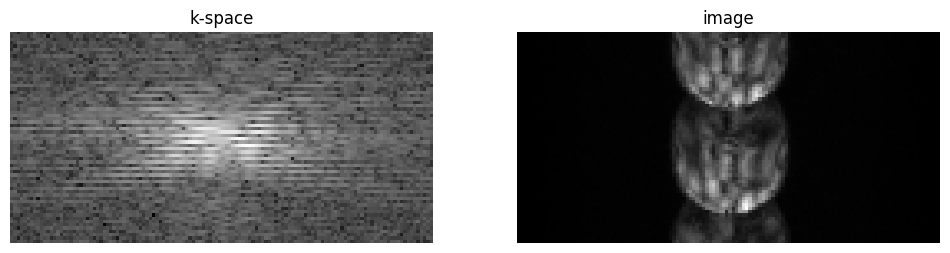

In [8]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix_raw[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

print('\nk-space shape', kspace.shape)

# reconstruct an image and show the result:
plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(kspace[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(kspace, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')

In [9]:
print(mdb.mdh.__class__.__dict__.keys())

dict_keys(['__module__', '_pack_', '_fields_', '__init__', '__doc__', 'FlagsAndDMALength', 'MeasUID', 'ScanCounter', 'TimeStamp', 'PMUTimeStamp', 'SystemType', 'PTABPosDelay', 'PTABPosX', 'PTABPosY', 'PTABPosZ', 'Reserved1', 'EvalInfoMask', 'SamplesInScan', 'UsedChannels', 'Counter', 'CutOff', 'CenterCol', 'CoilSelect', 'ReadOutOffcentre', 'TimeSinceLastRF', 'CenterLin', 'CenterPar', 'SliceData', 'IceProgramPara', 'ReservedPara', 'ApplicationCounter', 'ApplicationMask', 'CRC'])


(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

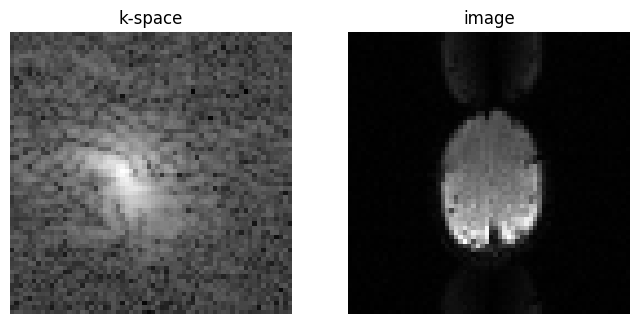

In [10]:
im_array = epi_map[-1]['image']
im_array.flags['remove_os'] = True

# read the data
data = im_array[:].squeeze()

# define timepoint and slice to reconstruct
t = 0
slice = 15


# reconstruct the data on given sliece and timepoint and conbine coils, ifftnd to get the image from k-space
image_before = ifftnd(data[t, slice], [0, -1])
image_before = rms_comb(image_before)

# plot the data
plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[t, slice][:, 0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(122)
plt.title('image')
plt.imshow(image_before, cmap='gray', origin='lower')
plt.axis('off')

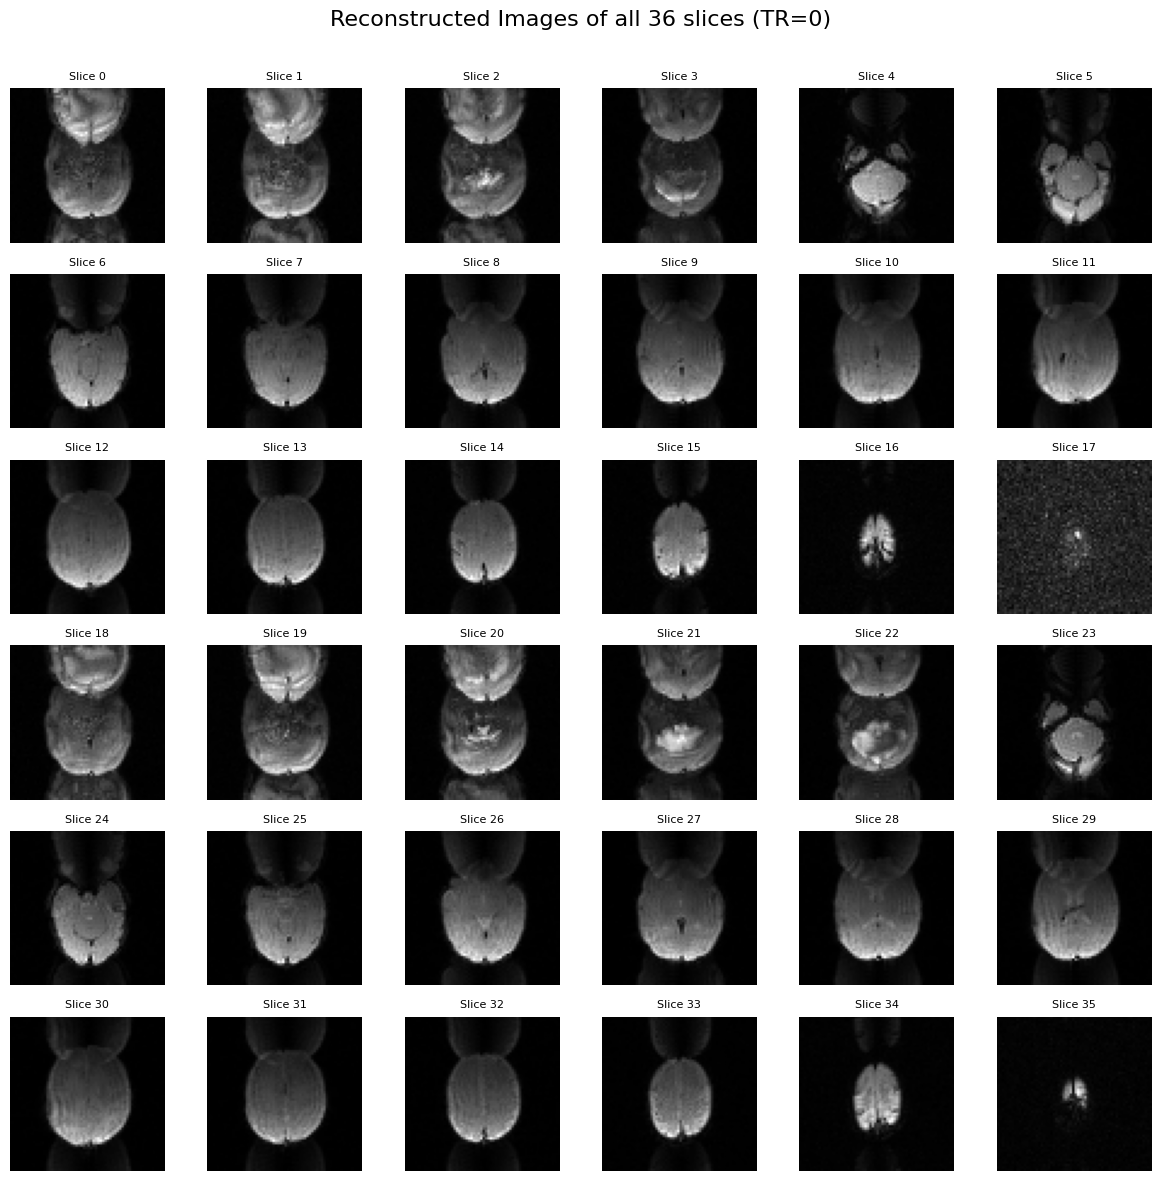

In [11]:


# # read the image twix object
# im_array = epi_map[-1]['image']
# im_array.flags['remove_os'] = True
# data = im_array[:].squeeze()      # shape (TR, SLI, LIN, CHA, COL)

t = 0                    # timepoint you want to plot
num_slices = data.shape[1]        # should be 36

# figure setup
plt.figure(figsize=(12, 12))
plt.suptitle(f"Reconstructed Images of all {num_slices} slices (TR={t})", fontsize=16)

for s in range(num_slices):

    # reconstruct image for this slice
    img = ifftnd(data[t, s], [0, -1])   # shape (LIN, CHA, COL)
    img_rss = rms_comb(img)             # coil combined

    ax = plt.subplot(6, 6, s+1)
    ax.imshow(np.abs(img_rss), cmap='gray', origin='lower')
    ax.set_title(f"Slice {s}", fontsize=8)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Phase correction 

phase corrected image shape: (10, 36, 64, 38, 64)
image before shape: (64, 64)
image before shape: (64, 64)


(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

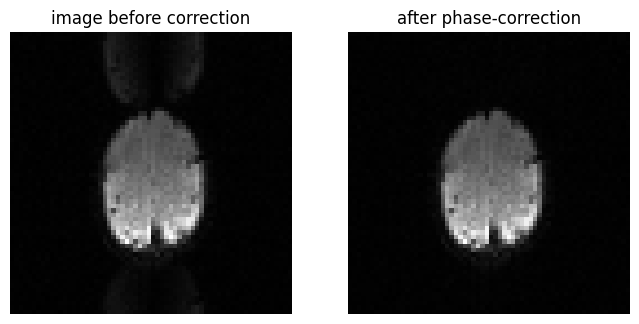

In [12]:
# functions to calculate & apply phase-correction:
import copy

def calc_pc_corr(sig):
    ncol = sig.shape[-1]

    # ifft col dim.
    pc = ifftnd(sig, [-1])

    # calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
    slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True).sum(-2, keepdims=True))
    x = np.arange(ncol) - ncol//2

    return np.exp(1j * slope * x)


def apply_pc_corr_and_ifft(sig, pc_corr):

    # ifft col dim.
    sig = ifftnd(sig, [-1])

    # apply phase-correction slope
    sig *= pc_corr

    # remove segment dim
    sig = sig.sum(5).squeeze()
    # print(sig.shape)

    # ifft lin dim.
    sig = ifftnd(sig, [2])

    return sig

timepoints = 10
t = 0
slice = 15

# for phase-correction, we need to keep the individual segments (which indicate the readout's polarity)
im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = False

pc_array = epi_map[-1]['phasecorr']
pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True
pc_array.flags['average']['Seg'] = False

pc_arr = pc_array[:, :, :, :, :, :, :, :timepoints]
im_arr =   im_array[:, :, :, :, :, :, :, :timepoints]

# # calculate phase-correction
pc_corr = calc_pc_corr(pc_arr[:])

# # apply phase-correction
corrected_img = apply_pc_corr_and_ifft(im_arr[:], pc_corr)

# corrected = compute_phase_correction(pc_arr)
# corrected_img = apply_phase_correction_and_ifft(im_arr, corrected)

print(f'phase corrected image shape: {corrected_img.shape}')

image_pc = corrected_img[t, slice]
# RMS coil combination# plot results
image_after = rms_comb(image_pc)

# get the image before from im_Array
# im_array_copy = copy.deepcopy(im_array)
im_array.flags['average']['Seg'] = True
# im_array.flags['squeeze_singletons'] = True

image_before = im_array[:].squeeze()
image_before = image_before[t, slice]
image_before = ifftnd(image_before, [0,-1])
image_before = rms_comb(image_before)
print(f'image before shape: {image_before.shape}')

plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('image before correction')
plt.imshow(image_before, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('after phase-correction')
plt.imshow(image_after, cmap='gray', origin='lower')
plt.axis('off')

# again enable the two polarities in the end 
# im_array.flags['average']['Seg'] = False

phase correction and regridding

(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

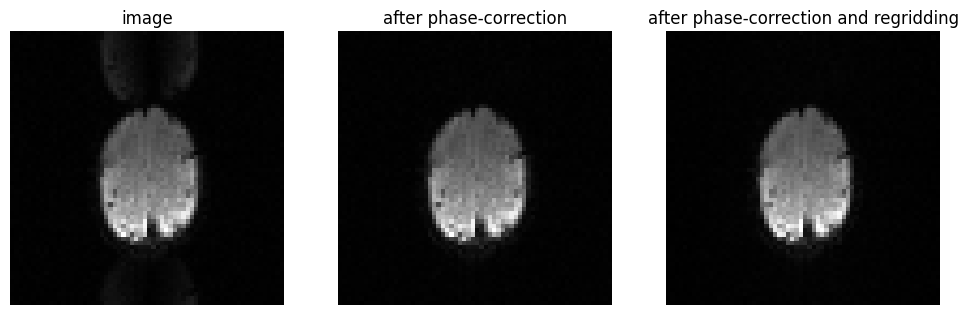

In [13]:
# activate regridding:
im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = False
im_array.flags['regrid'] = True

pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True
pc_array.flags['average']['Seg'] = False
pc_array.flags['regrid'] = True

pc_arr = pc_array[:, :, :, :, :, :, :, :timepoints]
im_arr =   im_array[:, :, :, :, :, :, :, :timepoints]

# calculate phase-correction
pc_corr = calc_pc_corr(pc_arr[:])

# apply phase-correction
image_pc_regrid = apply_pc_corr_and_ifft(im_arr[:], pc_corr)


t = 0
slice = 15

image_pc_regrid = image_pc_regrid[t, slice]
# RMS coil combination
image_pc_regrid = rms_comb(image_pc_regrid)

# plot results
plt.figure(figsize=[12,6])
plt.subplot(131)
plt.title('image')
plt.imshow(image_before, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(132)
plt.title('after phase-correction')
plt.imshow(image_after, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(133)
plt.title('after phase-correction and regridding')
plt.imshow(image_pc_regrid, cmap='gray', origin='lower')
plt.axis('off')

writing the modified and preporcessed data into a new file

In [14]:
# Apply your existing function
im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = False
im_array.flags['regrid'] = True

pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True
pc_array.flags['average']['Seg'] = False
pc_array.flags['regrid'] = True

timepoints = 10 

pc_arr = pc_array[:, :, :, :, :, :, :, :timepoints]
im_arr =   im_array[:, :, :, :, :, :, :, :timepoints]

pc_corr = calc_pc_corr(pc_arr[:])
img_pc = apply_pc_corr_and_ifft(im_arr[:], pc_corr)   # image space

# Go back to k-space
kspace_preprocessed = fftnd(img_pc, axes=[-3, -1])     # forward FFT both axes

# Save
sub_name = sub_file.split('.')[0]
np.savez_compressed(
    f"{sub_path}/{sub_name}_preprocessed.npz",
    kspace=kspace_preprocessed.astype(np.complex64)
)
print("Saved preprocessed k-space.")

Saved preprocessed k-space.


load and read the preprocessed k-space 

In [3]:
import numpy as np
data_path = "/Users/faizan/Documents/freezemotion/fmri_reco/implementations/twixtools/example_data"
single_band = np.load(f"{data_path}/meas_MID00049_FID80434_cmrr_SBep2d_se_AP_RDS_preprocessed.npz")
sms_image = np.load(f"{data_path}/meas_MID00046_FID80431_cmrr_mbep2d_videos_AP_RDS_preprocessed.npz")

kspace_single_band = single_band['kspace']
kspace_sms = sms_image['kspace']

# print the shapes 
# print("Loaded k-space:", kspace_preprocessed.shape)
print("Single-band k-space:", kspace_single_band.shape)
print("SMS k-space:", kspace_sms.shape)

Single-band k-space: (10, 36, 64, 38, 64)
SMS k-space: (10, 36, 64, 38, 64)


In [ ]:
# data = np.load(f"{sub_path}/{sub_name}_preprocessed.npz")
kspace_preprocessed = data["kspace"]
print("Loaded k-space:", kspace_preprocessed.shape)


Loaded k-space: (10, 36, 64, 38, 64)


plot loaded data 

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

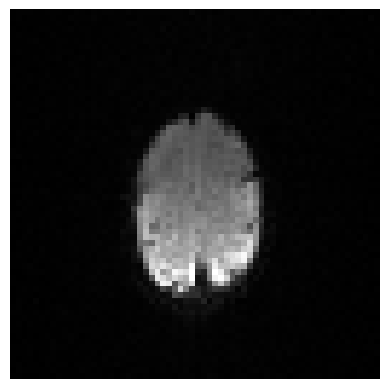

In [16]:
img = ifftnd(kspace_preprocessed[t, 15], [0, -1])

# Fix vertical flip introduced by FFT / k-space ordering
img = np.flip(img, axis=0)

img_rss = rms_comb(img, axis=1)
# print(img_rss.dtype)
plt.imshow(np.abs(img_rss), cmap='gray')
plt.axis('off')


plotting reference or measurement 0 across slices 

(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(31.5))

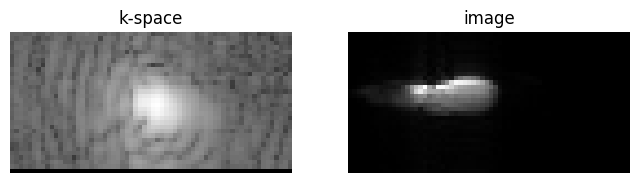

In [17]:
meas_indx = 0
ref_im_array = epi_map[0]['image']
ref_im_array.flags['remove_os'] = True
if meas_indx == 0:
    ref_im_array.flags["squeeze_singletons"] = True
    # read the data
    ref_data = ref_im_array[0]
else:
    ref_data = ref_im_array[:].squeze()

# define timepoint and slice to reconstruct
t = 0
slice = 30


# reconstruct the data on given sliece and timepoint and conbine coils, ifftnd to get the image from k-space
if meas_indx != 0:
    ref_image = ifftnd(ref_data[t, slice], [0,-1])
else:
    par = 15
    ref_image = ifftnd(ref_data[par], [0,-1])
ref_coil_combined_image = rms_comb(ref_image)

# plot the data
plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(ref_data[par][:, 0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(122)
plt.title('image')
plt.imshow(ref_coil_combined_image, cmap='gray', origin='lower')
plt.axis('off')

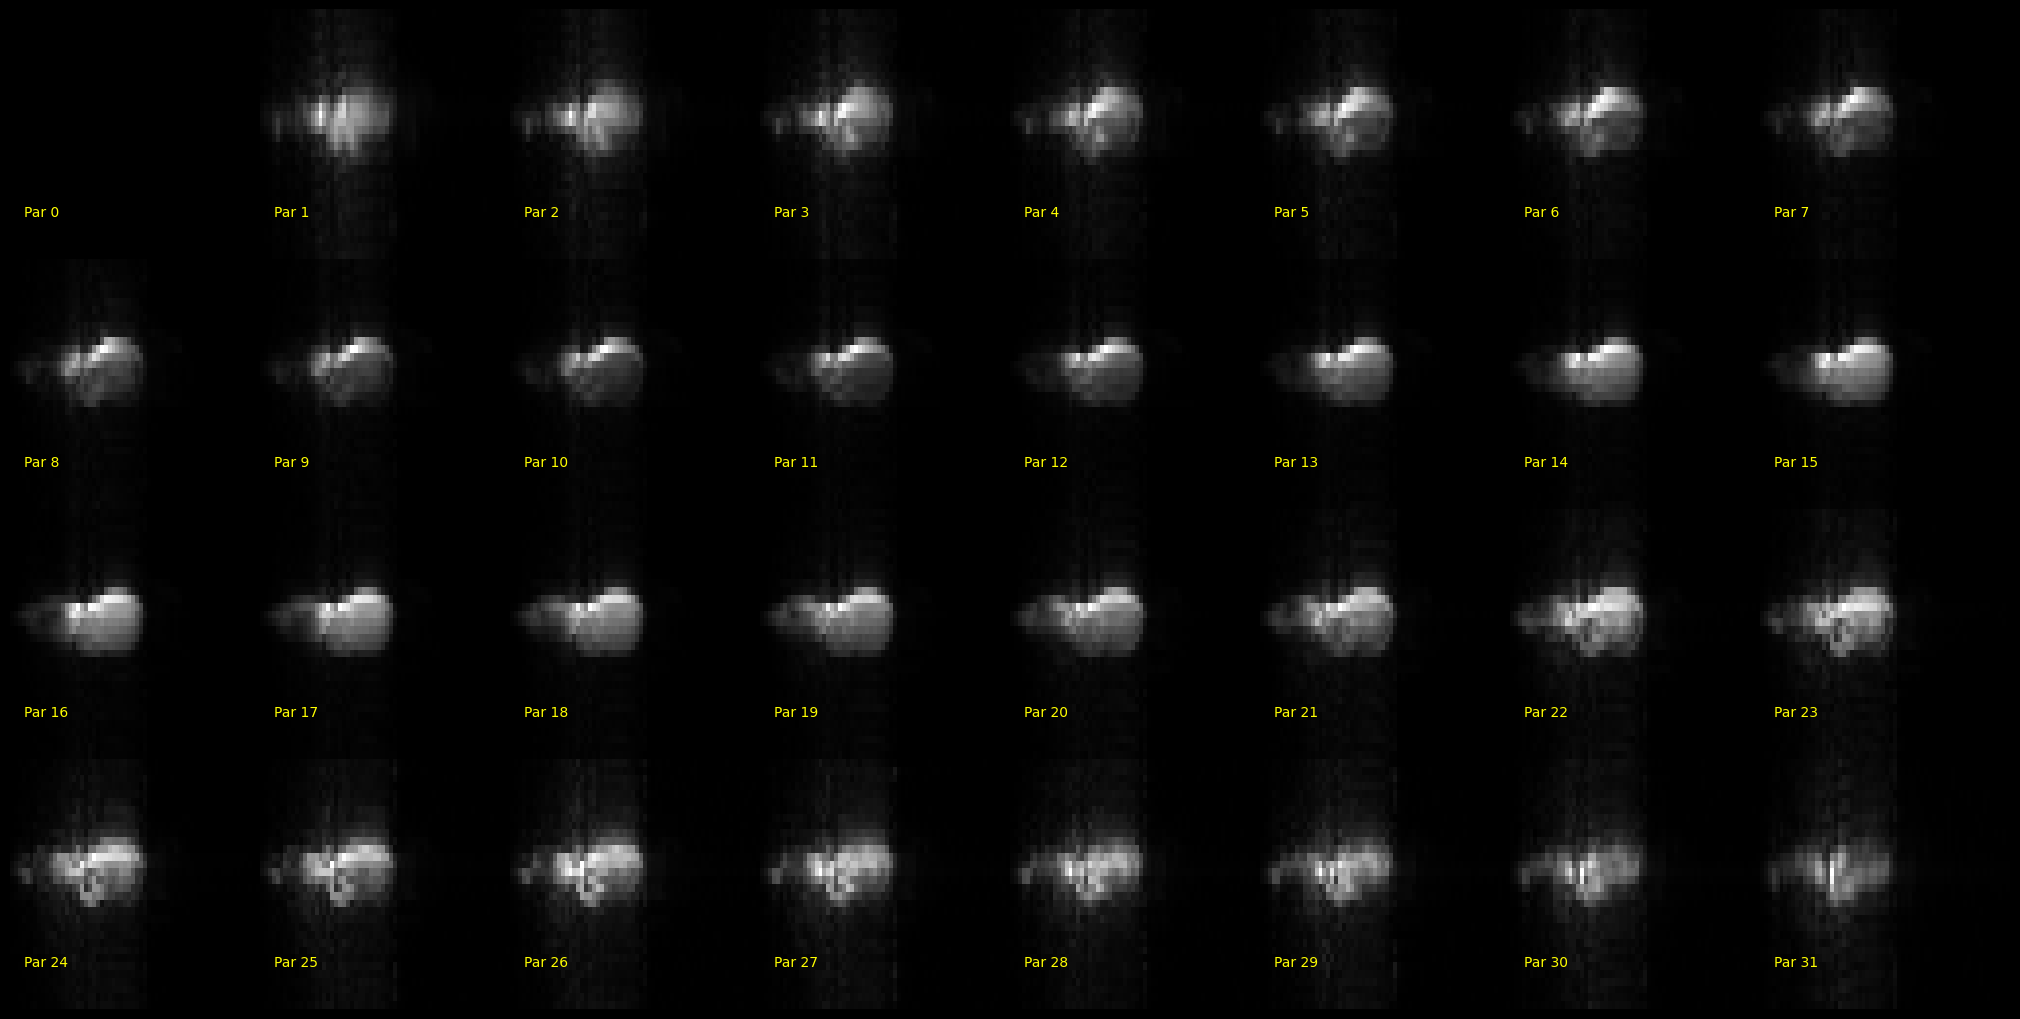

In [18]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('black')

rows, cols = 4, 8
Npar = 32

tile_w = 1.0 / cols
tile_h = 1.0 / rows

for p in range(Npar):

    img = ifftnd(ref_data[p], [0, -1])
    img_rss = rms_comb(img)

    r = p // cols
    c = p % cols

    x0 = c * tile_w
    y0 = 1.0 - (r+1) * tile_h

    ax = fig.add_axes([x0, y0, tile_w, tile_h])
    
    # ⭐ IMPORTANT FIX: force tile to stretch image (removes vertical black gaps)
    ax.imshow(np.abs(img_rss), cmap='gray', origin='lower', aspect='auto')

    # optional: ensure background is black
    ax.set_facecolor('black')

    ax.text(3, 5, f"Par {p}", color="yellow", fontsize=10)
    ax.axis("off")

plt.show()


Calculate the Ghost to signal ration (GSR) to validate the ghost correction
 - use opencv to get teh accurate mask of the brain region
 - use that mask to create ghost mask
 - write GSR code
 -  plotting and ratio

      Ghost-to-Signal Ratio (GSR)              
Signal Mean (Before): 0.0005
Ghost  Mean (Before): 0.0001
GSR Before          : 0.139526
-----------------------------------------------
Signal Mean (After) : 0.0005
Ghost  Mean (After) : 0.0000
GSR After           : 0.058742
-----------------------------------------------
GSR Reduction       : 0.080783


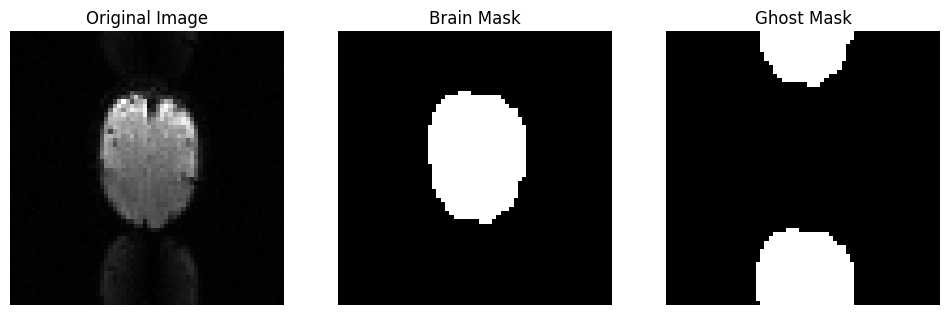

In [19]:
import cv2
# ---------------------------------------------------------
# Brain mask extraction
# ---------------------------------------------------------
def extract_brain_mask(img):
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_uint8 = (img_norm * 255).astype(np.uint8)

    blur = cv2.GaussianBlur(img_uint8, (5,5), 0)

    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_closed)

    if num_labels <= 1:
        return mask_closed.astype(bool)

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    brain_mask = (labels == largest_label)

    return brain_mask.astype(bool)

# ---------------------------------------------------------
# Ghost mask
# ---------------------------------------------------------
def create_ghost_mask(brain_mask):
    Ny = brain_mask.shape[0]
    shift = Ny // 2

    ghost_mask_up   = np.roll(brain_mask, -shift, axis=0)
    ghost_mask_down = np.roll(brain_mask,  shift, axis=0)

    ghost_mask = (ghost_mask_up | ghost_mask_down)
    ghost_mask = ghost_mask & (~brain_mask)

    return ghost_mask.astype(bool)

# ---------------------------------------------------------
# Compute GSR
# ---------------------------------------------------------
def compute_gsr(img, brain_mask, ghost_mask):
    img_abs = np.abs(img)

    signal_mean = img_abs[brain_mask].mean()
    ghost_mean  = img_abs[ghost_mask].mean()

    gsr = ghost_mean / (signal_mean + 1e-12)

    return gsr, signal_mean, ghost_mean

# ---------------------------------------------------------
# Compute GSR Before and After Correction
# ---------------------------------------------------------
def compare_gsr(image_before, image_after):

    # 1. Brain mask extracted from BEFORE-correction image
    brain_mask = extract_brain_mask(image_before)

    # 2. Ghost mask
    ghost_mask = create_ghost_mask(brain_mask)

    # 3. Compute GSR before and after
    gsr_before, sig_b, ghost_b = compute_gsr(image_before, brain_mask, ghost_mask)
    gsr_after,  sig_a, ghost_a = compute_gsr(image_after,  brain_mask, ghost_mask)

    # Print results
    print("===============================================")
    print("      Ghost-to-Signal Ratio (GSR)              ")
    print("===============================================")
    print(f"Signal Mean (Before): {sig_b:.4f}")
    print(f"Ghost  Mean (Before): {ghost_b:.4f}")
    print(f"GSR Before          : {gsr_before:.6f}")
    print("-----------------------------------------------")
    print(f"Signal Mean (After) : {sig_a:.4f}")
    print(f"Ghost  Mean (After) : {ghost_a:.4f}")
    print(f"GSR After           : {gsr_after:.6f}")
    print("-----------------------------------------------")
    print(f"GSR Reduction       : {gsr_before - gsr_after:.6f}")
    print("===============================================")

    # Optional: visualize masks
    plt.figure(figsize=(12,4))
    plt.subplot(131); plt.imshow(image_before, cmap='gray'); plt.title("Original Image"); plt.axis('off')
    plt.subplot(132); plt.imshow(brain_mask, cmap='gray'); plt.title("Brain Mask"); plt.axis('off')
    plt.subplot(133); plt.imshow(ghost_mask, cmap='gray'); plt.title("Ghost Mask"); plt.axis('off')
    plt.show()

    return gsr_before, gsr_after

# ---------------------------------------------------------
# Run it on your images
# ---------------------------------------------------------
gsr_before, gsr_after = compare_gsr(image_before, image_after)


plot for all the imaeges corrected and non corrected

      Ghost-to-Signal Ratio (GSR)              
Signal Mean (Before): 0.0005
Ghost  Mean (Before): 0.0001
GSR Before          : 0.139526
-----------------------------------------------
Signal Mean (After) : 0.0005
Ghost  Mean (After) : 0.0000
GSR After           : 0.058742
-----------------------------------------------
GSR Reduction       : 0.080783


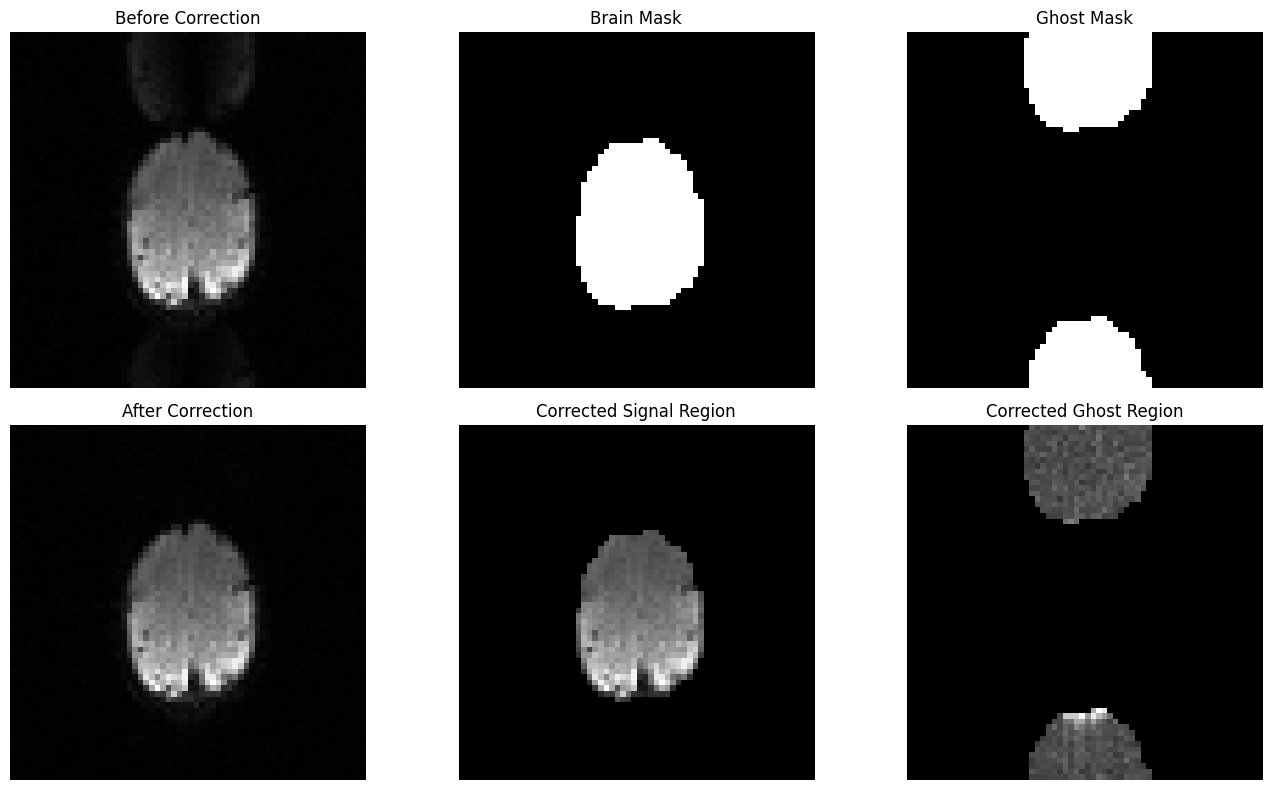

In [20]:
import cv2
# ---------------------------------------------------------
# Brain mask extraction
# ---------------------------------------------------------
def extract_brain_mask(img):
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_uint8 = (img_norm * 255).astype(np.uint8)

    blur = cv2.GaussianBlur(img_uint8, (5,5), 0)

    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_closed)

    if num_labels <= 1:
        return mask_closed.astype(bool)

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    brain_mask = (labels == largest_label)

    return brain_mask.astype(bool)

# ---------------------------------------------------------
# Ghost mask
# ---------------------------------------------------------
def create_ghost_mask(brain_mask):
    Ny = brain_mask.shape[0]
    shift = Ny // 2

    ghost_mask_up   = np.roll(brain_mask, -shift, axis=0)
    ghost_mask_down = np.roll(brain_mask,  shift, axis=0)

    ghost_mask = (ghost_mask_up | ghost_mask_down)
    ghost_mask = ghost_mask & (~brain_mask)

    return ghost_mask.astype(bool)

# ---------------------------------------------------------
# Compute GSR
# ---------------------------------------------------------
def compute_gsr(img, brain_mask, ghost_mask):
    img_abs = np.abs(img)

    signal_mean = img_abs[brain_mask].mean()
    ghost_mean  = img_abs[ghost_mask].mean()

    gsr = ghost_mean / (signal_mean + 1e-12)

    return gsr, signal_mean, ghost_mean


# ---------------------------------------------------------
# Compute GSR Before and After + PLOTS (2 rows × 3 cols)
# ---------------------------------------------------------
def compare_gsr(image_before, image_after):

    # 1. Extract masks
    brain_mask = extract_brain_mask(image_before)
    ghost_mask = create_ghost_mask(brain_mask)

    # 2. Compute GSR
    gsr_before, sig_b, ghost_b = compute_gsr(image_before, brain_mask, ghost_mask)
    gsr_after,  sig_a, ghost_a = compute_gsr(image_after,  brain_mask, ghost_mask)

    # 3. Print results
    print("===============================================")
    print("      Ghost-to-Signal Ratio (GSR)              ")
    print("===============================================")
    print(f"Signal Mean (Before): {sig_b:.4f}")
    print(f"Ghost  Mean (Before): {ghost_b:.4f}")
    print(f"GSR Before          : {gsr_before:.6f}")
    print("-----------------------------------------------")
    print(f"Signal Mean (After) : {sig_a:.4f}")
    print(f"Ghost  Mean (After) : {ghost_a:.4f}")
    print(f"GSR After           : {gsr_after:.6f}")
    print("-----------------------------------------------")
    print(f"GSR Reduction       : {gsr_before - gsr_after:.6f}")
    print("===============================================")

    # 4. Masked images
    signal_before  = np.abs(image_before) * brain_mask
    ghost_before   = np.abs(image_before) * ghost_mask

    signal_after   = np.abs(image_after) * brain_mask
    ghost_after    = np.abs(image_after) * ghost_mask

    # 5. PLOTS — 2 rows × 3 cols
    plt.figure(figsize=(14, 8))

    # ---- Row 1: BEFORE correction ----
    plt.subplot(2, 3, 1)
    plt.title("Before Correction")
    plt.imshow(image_before, cmap="gray", origin="lower")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.title("Brain Mask")
    plt.imshow(brain_mask, cmap="gray", origin="lower")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.title("Ghost Mask")
    plt.imshow(ghost_mask, cmap="gray", origin="lower")
    plt.axis("off")

    # ---- Row 2: AFTER correction ----
    plt.subplot(2, 3, 4)
    plt.title("After Correction")
    plt.imshow(image_after, cmap="gray", origin="lower")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.title("Corrected Signal Region")
    plt.imshow(signal_after, cmap="gray", origin="lower")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.title("Corrected Ghost Region")
    plt.imshow(ghost_after, cmap="gray", origin="lower")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return gsr_before, gsr_after


# ---------------------------------------------------------
# Run it on your images
# ---------------------------------------------------------
gsr_before, gsr_after = compare_gsr(image_before, image_after)


# Slice GRAPPA
 - unfold slices 
 - load MB file and SB file
 - load fMRI for both
 - run slice GRAPPA 

load each of the files 

loaded the preprocessed k-space data for both single band and multiband


In [21]:
sb_band_kspace = "meas_MID00049_FID80434_cmrr_SBep2d_se_AP_RDS_preprocessed.npz"
mb_band_kspace = "meas_MID00046_FID80431_cmrr_mbep2d_videos_AP_RDS_preprocessed.npz"

data_sb_kspace = np.load(os.path.join(sub_path, sb_band_kspace))
data_mb_kspace = np.load(os.path.join(sub_path, mb_band_kspace))
kspace_preprocessed_sb = data_sb_kspace["kspace"]
kspace_preprocessed_mb = data_mb_kspace["kspace"]
print("Loaded single band k-space:", kspace_preprocessed_sb.shape)
print("Loaded multi band k-space:", kspace_preprocessed_mb.shape)



Loaded single band k-space: (10, 36, 64, 38, 64)
Loaded multi band k-space: (10, 36, 64, 38, 64)


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

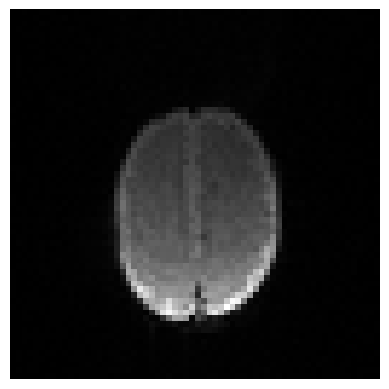

In [22]:
img = ifftnd(kspace_preprocessed_sb[t, 15], [0, -1])

# Fix vertical flip introduced by FFT / k-space ordering
img = np.flip(img, axis=0)

img_rss = rms_comb(img, axis=1)
# print(img_rss.dtype)
plt.imshow(np.abs(img_rss), cmap='gray')
plt.axis('off')


In [23]:
from pygrappa.slicegrappa import slicegrappa
import numpy as np

MB = 4
T_mb, S, Lin, Cha, Col = kspace_preprocessed_mb.shape
T_sb, S2, _, _, _      = kspace_preprocessed_sb.shape

assert S == S2

base = S // MB   # 9 MB groups

# output array for fully unaliased k-space
reco_full = np.zeros_like(kspace_preprocessed_mb, dtype=np.complex64)

for b in range(base):

    # ---- slice indices for MB group b ----
    sli_idx = b + base * np.arange(MB)  # e.g. [0,9,18,27]

    # ---- calibration: SB (first volume) ----
    calib = kspace_preprocessed_sb[0, sli_idx, ...]   # (MB, Lin, Cha, Col)

    # ---- collapsed MB data (sum of the 4 aliased slices) ----
    kspace_pack = kspace_preprocessed_mb[:, sli_idx, ...].sum(axis=1)
    # shape: (T_mb, Lin, Cha, Col)

    # ---- slice-GRAPPA ----
    res = slicegrappa(
        kspace=kspace_pack,   # (T_mb, Lin, Cha, Col)
        calib=calib,          # (MB, Lin, Cha, Col)
        kernel_size=(5, 5),
        prior='sim',
        coil_axis=2,          # Cha axis in both arrays
        time_axis=0,          # time is axis 0 in MB data
        slice_axis=0,         # slice is axis 0 in calib
        lamda=0.01,
        split=False
    )

    # res shape: (Lin, Col, Cha, T, MB)

    # ---- reorder to (T, S, Lin, Cha, Col) ----
    # We want to insert unaliased slices back into reco_full
    # move axis (Lin, Col, Cha, T, MB) -> (T, MB, Lin, Cha, Col)

    res_group = np.moveaxis(res, (0,1,2,3,4), (2,4,3,0,1))
    # res_group shape: (T_mb, MB, Lin, Cha, Col)

    reco_full[:, sli_idx, ...] = res_group

print("Full unaliased k-space shape:", reco_full.shape)


/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:131: RuntimeWarning: divide by zero encountered in matmul
  ShS = S.conj().T @ S
/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:131: RuntimeWarning: overflow encountered in matmul
  ShS = S.conj().T @ S
/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:131: RuntimeWarning: invalid value encountered in matmul
  ShS = S.conj().T @ S
/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:132: RuntimeWarning: divide by zero encountered in matmul
  ShT = S.conj().T @ T
/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:132: RuntimeWarning: overflow encountered in matmul
  ShT = S.conj().T @ T
/opt/anaconda3/envs/fmri_reco/lib/python3.10/site-packages/pygrappa/slicegrappa.py:132: RuntimeWarning: invalid value encountered in matmul
  ShT = S.conj().T @ T
                              

Full unaliased k-space shape: (10, 36, 64, 38, 64)


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

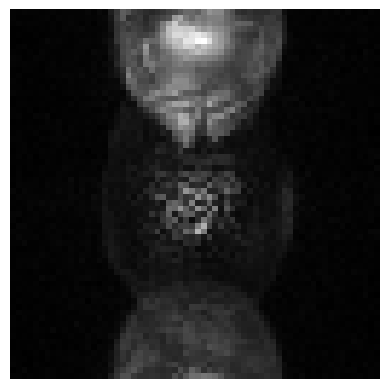

In [24]:
t = 0
sl = 0

img = ifftnd(reco_full[t, sl], axes=[0, -1])
img = np.flip(img, axis=0)
rss = rms_comb(img, axis=1)

plt.imshow(np.abs(rss), cmap='gray')
plt.axis('off')


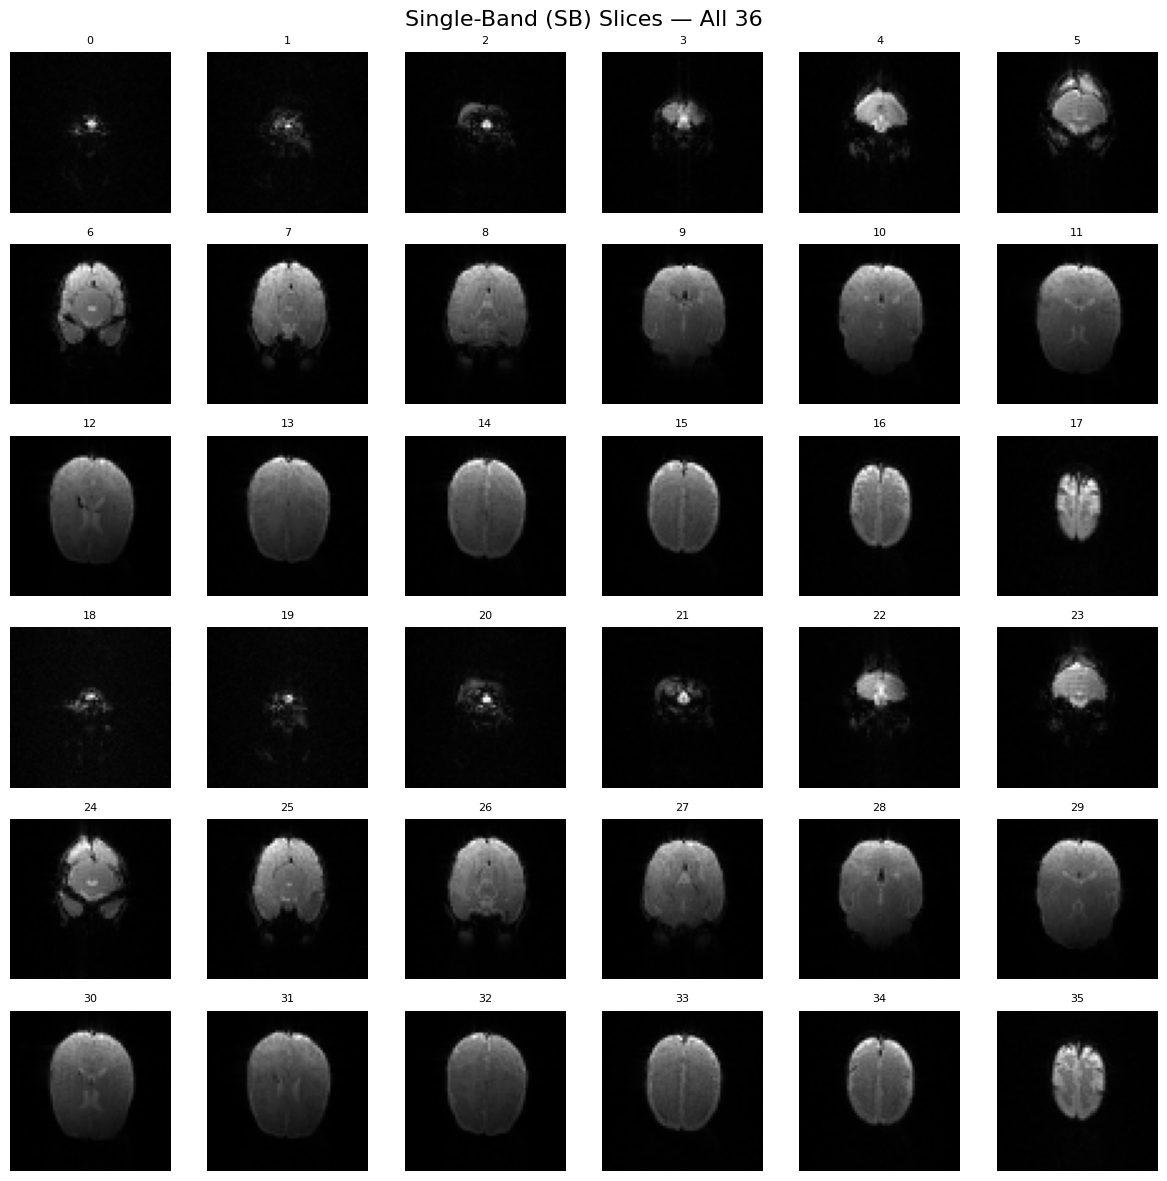

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Create 6x6 subplot grid
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.suptitle("Single-Band (SB) Slices — All 36", fontsize=16)

for sli in range(36):
    ax = axes[sli // 6, sli % 6]

    # Reconstruct slice
    img = ifftnd(kspace_preprocessed_sb[0, sli], axes=[0, -1])
    rss = rms_comb(img, axis=1)

    ax.imshow(np.abs(rss), cmap='gray')
    ax.set_title(f"{sli}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


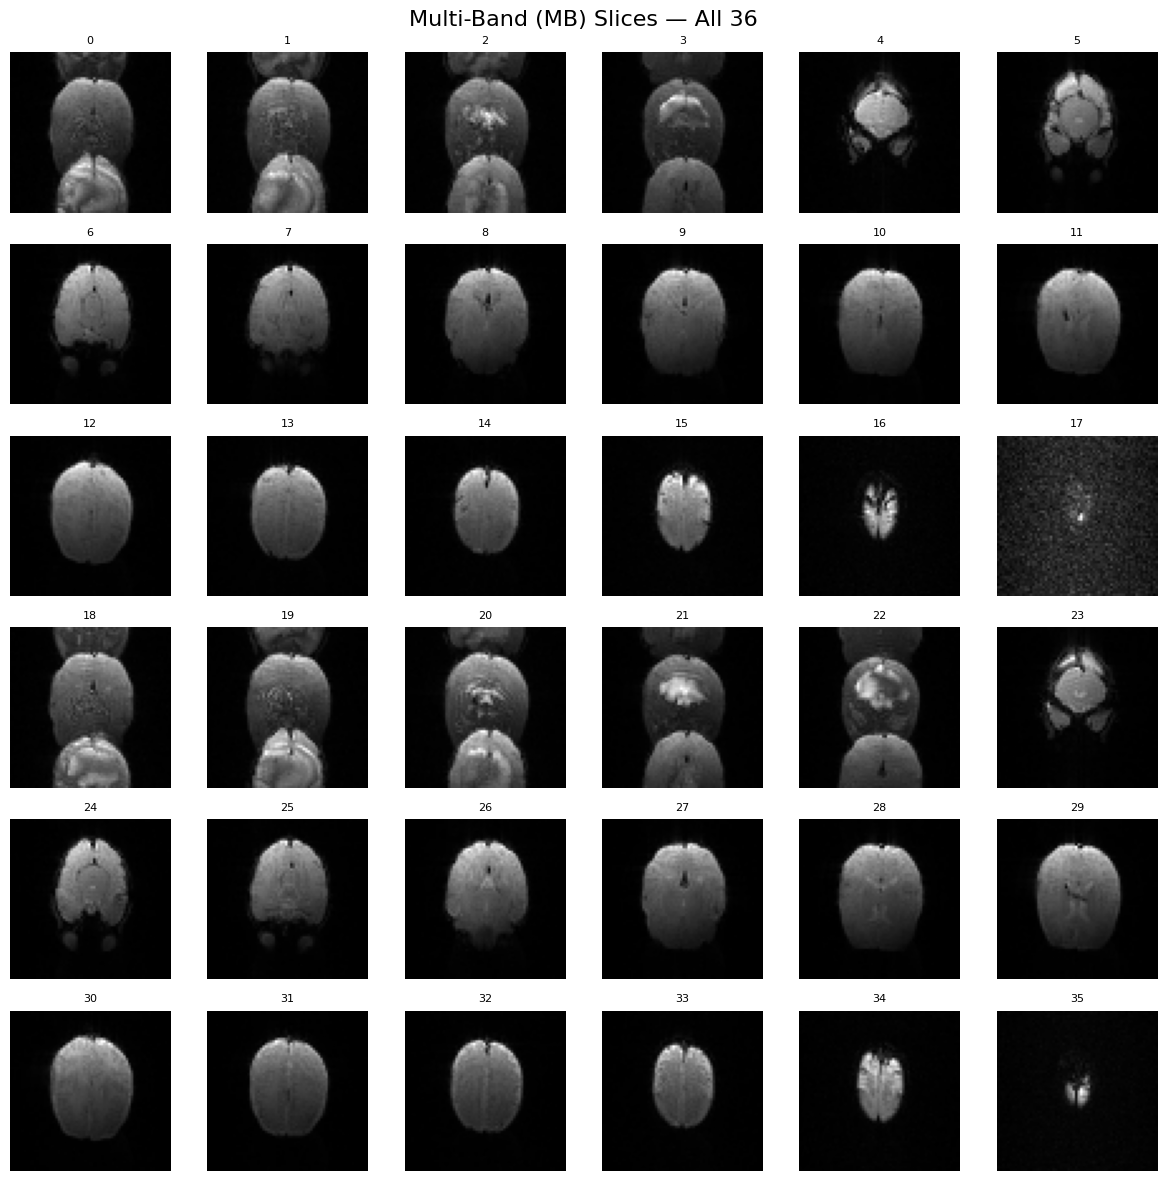

In [26]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.suptitle("Multi-Band (MB) Slices — All 36", fontsize=16)

for sli in range(36):
    img = ifftnd(kspace_preprocessed_mb[0, sli], axes=[0, -1])
    rss = rms_comb(img, axis=1)

    ax = axes[sli // 6, sli % 6]
    ax.imshow(np.abs(rss), cmap='gray')
    ax.set_title(f"{sli}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

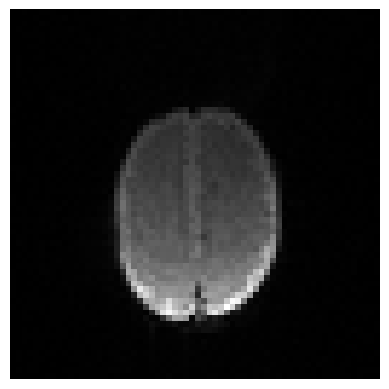

In [27]:
img_sb = ifftnd(kspace_preprocessed_sb[0, 15], [0, -1])
img_sb = np.flip(img_sb, axis=0)
rss_sb = rms_comb(img_sb)
plt.imshow(abs(rss_sb), cmap='gray')
plt.axis('off')

# img = ifftnd(kspace_preprocessed_sb[t, 15], [0, -1])

# # Fix vertical flip introduced by FFT / k-space ordering
# img = np.flip(img, axis=0)

# img_rss = rms_comb(img, axis=1)
# # print(img_rss.dtype)
# plt.imshow(np.abs(img_rss), cmap='gray')
# plt.axis('off')
